# BE/Bi 103, Fall 2016: Homework 5
## Due 1pm, Sunday, October 30

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw4.ipynb).*

In [142]:
import numpy as np
import numba
import pandas as pd
import sklearn.neighbors
import sklearn.preprocessing
import scipy.stats as st
import skimage.filters
import matplotlib.path
import matplotlib._cntr

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

import emcee
import corner

import bebi103

# Make Matplotlib plots appear inline
%matplotlib inline

### Problem 5.1: solutions

We will start with the extra credit first, showing how we do automatic gating. Before beginning the gating procedure, we will load in a test data set and extract the front scattering area, side scattering area, and fluorescence from the DataFrame. We will only consider 

In [225]:
# Get scattering data as a NumPy array for speed
df = pd.read_csv('../data/flow_data/20160804_wt_O2_RBS1027_10uMIPTG.csv',
                index_col=0).dropna()
inds = (df['FSC-A'] > 0) & (df['SSC-A'] > 0) & (df['FITC-A'] > 0)
fsc, ssc, yfp = df.loc[inds,['FSC-A', 'SSC-A', 'FITC-A']].values.transpose()

#### Gating with the histogram method

For the first method, we do the following.
1. Compute a 2D histogram of the front/side scattering data.
2. Optionally smooth the 2D histogram with a Gaussian filter.
3. Draw a contour corresponding to a given percentile. E.g., if we want only the data points that with the most often encountered front/side scattering pairs, we would choose a high percentile, like 90.
4. Retain all points within this contour.

To get a feel for how it works, let's first plot our data with some contours. We will plot the contours that contain the top 10, 20, 50, and 80 percent of the data.

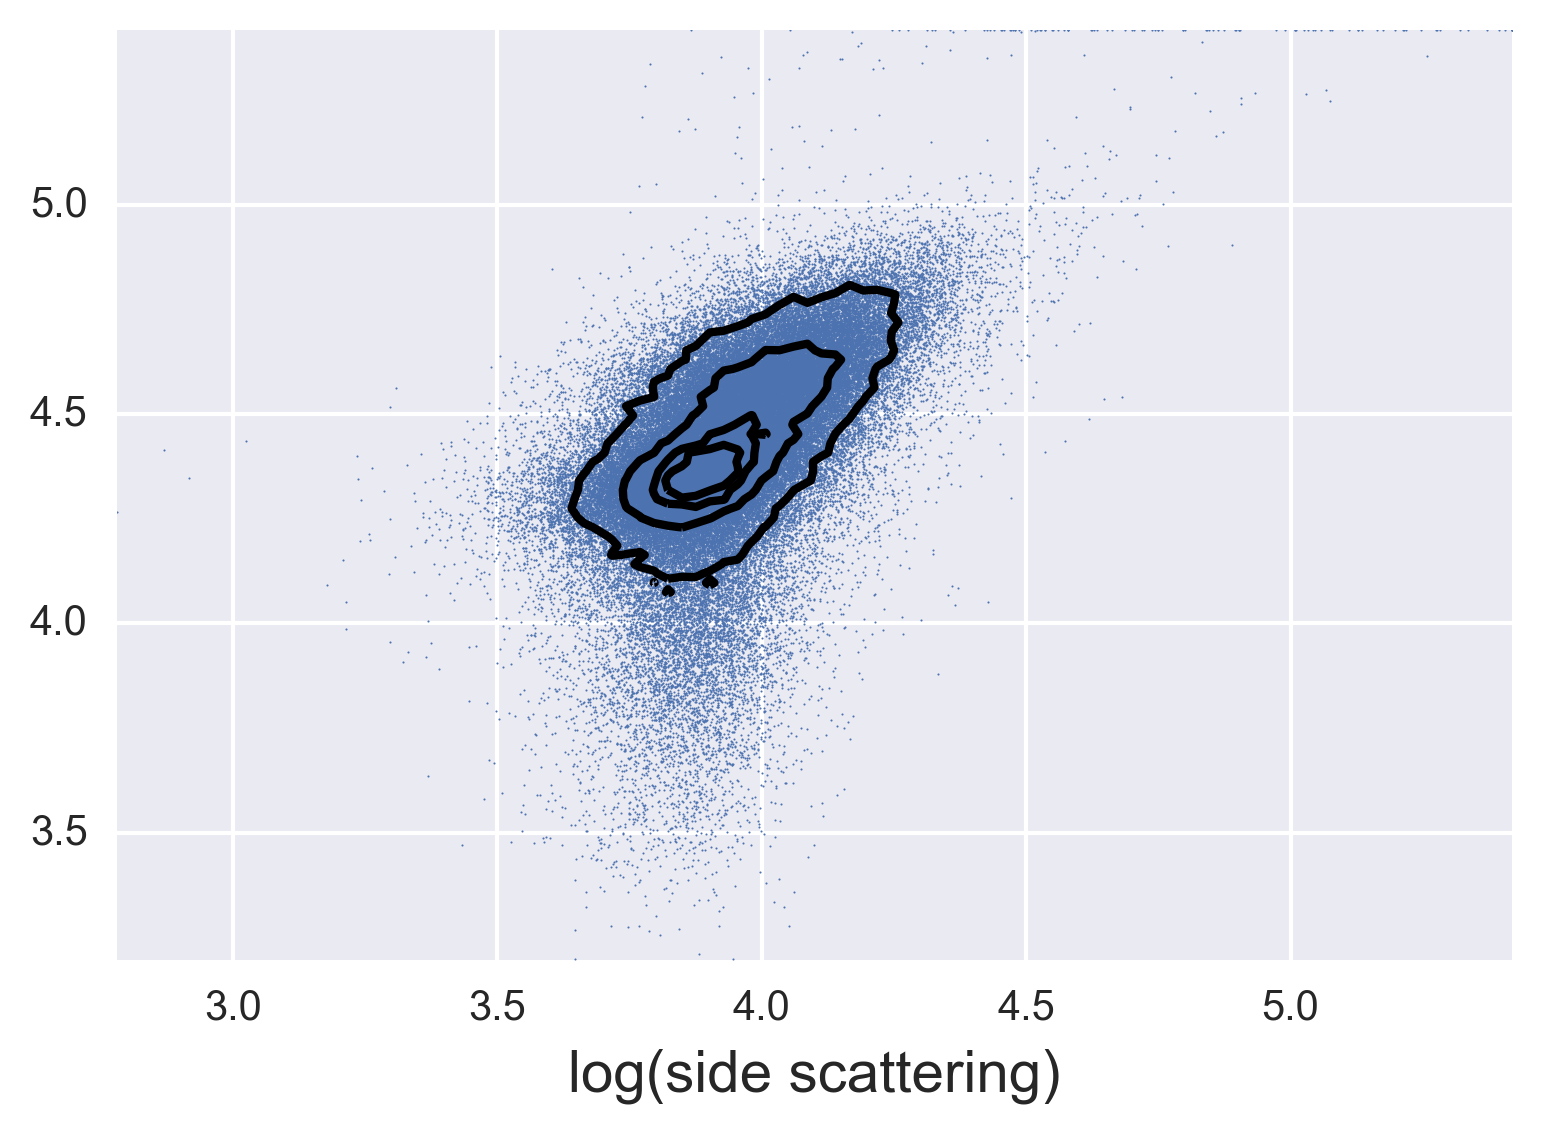

In [226]:
# Generate x, y, z data for histogram
z, x, y = bebi103.norm_cumsum_2d(np.log10(fsc), np.log10(ssc), bins=100)

# Plot the data
plt.plot(np.log10(fsc), np.log10(ssc), '.', markersize=1, rasterized=True)

# Plot contours for 50th, 80th, and 90th percentiles
plt.contour(x, y, z, levels=[0.1, 0.2, 0.5, 0.8], colors='black', zorder=3)

# Label axes
plt.xlabel('log(front scattering)')
plt.xlabel('log(side scattering)');

We might want to choose all of the points in the innermost contour, which would correspond to the 90th percentile and above.

To code this up, we first need to pay attention to the fact that sometimes the contours are disconnected. For example, in the above plot, we can see that at the outermost contour, there are a couple small contours disconnected from the large one. We want to only consider the largest contour, so we'll write a function to compute the area of a contour.

In [227]:
def shoelace_area(x, y):
    """
    Compute the area of a regular polygon using the shoelace formula.
    
    Parameters
    ----------
    x : ndarray
        x-coordinates of vertices of regular polygon
    y : ndarray
        y-coordinates of verticies of regular polygon
        
    Returns
    -------
    output : float
        Area of regular polygon.
    
    Notes
    -----
    .. See https://en.wikipedia.org/wiki/Shoelace_formula.

    .. If the polygon is irregular (has crossing lines), the result
       will be bogus, and no warning will be given.
    """
    return np.abs(np.dot(x, np.roll(y, 1)) - np.dot(np.roll(x, 1), y)) / 2    

Now that we have that, we can code up our gating. The function will return an array of Booleans that say whether or not we should include a given data point. In this function, we use the `matplotlib._cntr` submodule, which is deep the guts of Matplotlib, which is what generates the contours under the hood.

In [228]:
def gate_histogram(fsc, ssc, bins=100, uselog=True, percentile=80, 
                   smooth_sigma=None):
    """
    Gate flow data using the 2D histogram method.
    
    Parameters
    ----------
    fsc : ndarray
        Front scattering data
    ssc : ndarray
        Side scattering data
    bins : int, default 100
        Number of bins along each access to use in histogram
    uselog : bool, default True
        If True, use the logarithm of scattering data to generate
        histogram.
    percentile : float, default 80
        Include data points within a contour that encompasses the
        highest percentile of the data. E.g., if percentile = 90,
        data points within the contour containing the top 10% densest
        regions are used.
    smooth_sigma : float, default None
        If not None, then Gaussian smoothing is applied to the 
        2D histogram prior to drawing the contour. The smoothing kernel
        has sigma equal to smooth_sigma * extent of data. Recommended value
        is smooth_sigme = 0.01.
        
    Returns
    -------
    inds : ndarray of bools
        inds[i] is True if cell i is to be included and False otherwise.
        
    Notes
    -----
    .. It is not always possible to draw a contour. This most often
       happens when uselog=False and Gaussian smoothing is applied.
    """
    
    # Generate a 2D normalized histogram of data
    if uselog:
        z, x, y = bebi103.norm_cumsum_2d(np.log(fsc), np.log(ssc), bins=bins)
    else:
        z, x, y = bebi103.norm_cumsum_2d(fsc, ssc, bins=bins)

    # Smooth the histogram
    if smooth_sigma is not None:
        sigma = smooth_sigma * bins
        z = skimage.filters.gaussian(z, sigma)
        
    # Get the contour
    xx, yy = np.meshgrid(x, y)
    contour = matplotlib._cntr.Cntr(xx, yy, z)
    c = contour.trace((100-percentile) / 100)
    
    # Check to make sure we could generate a contour
    if len(c) == 0:
        raise RuntimeError('Unable to draw contour. Check input settings.')
    
    # Extract only polygons (last half of list is matplotlib details)
    c = c[:len(c)//2]
 
    # Use the contour that has the most area
    ind = np.argmax(np.array([shoelace_area(*pgon.T) for pgon in c]))

    # Make a matplotlib Path object so we can see if points are inside
    polygon = matplotlib.path.Path(c[ind][:-1])
    
    # Get points within polygon
    if uselog:
        return polygon.contains_points(np.vstack((np.log(fsc), np.log(ssc))).T)
    else:
        return polygon.contains_points(np.vstack((fsc, ssc)).T)

Now let's try gating this sample and plot the results.

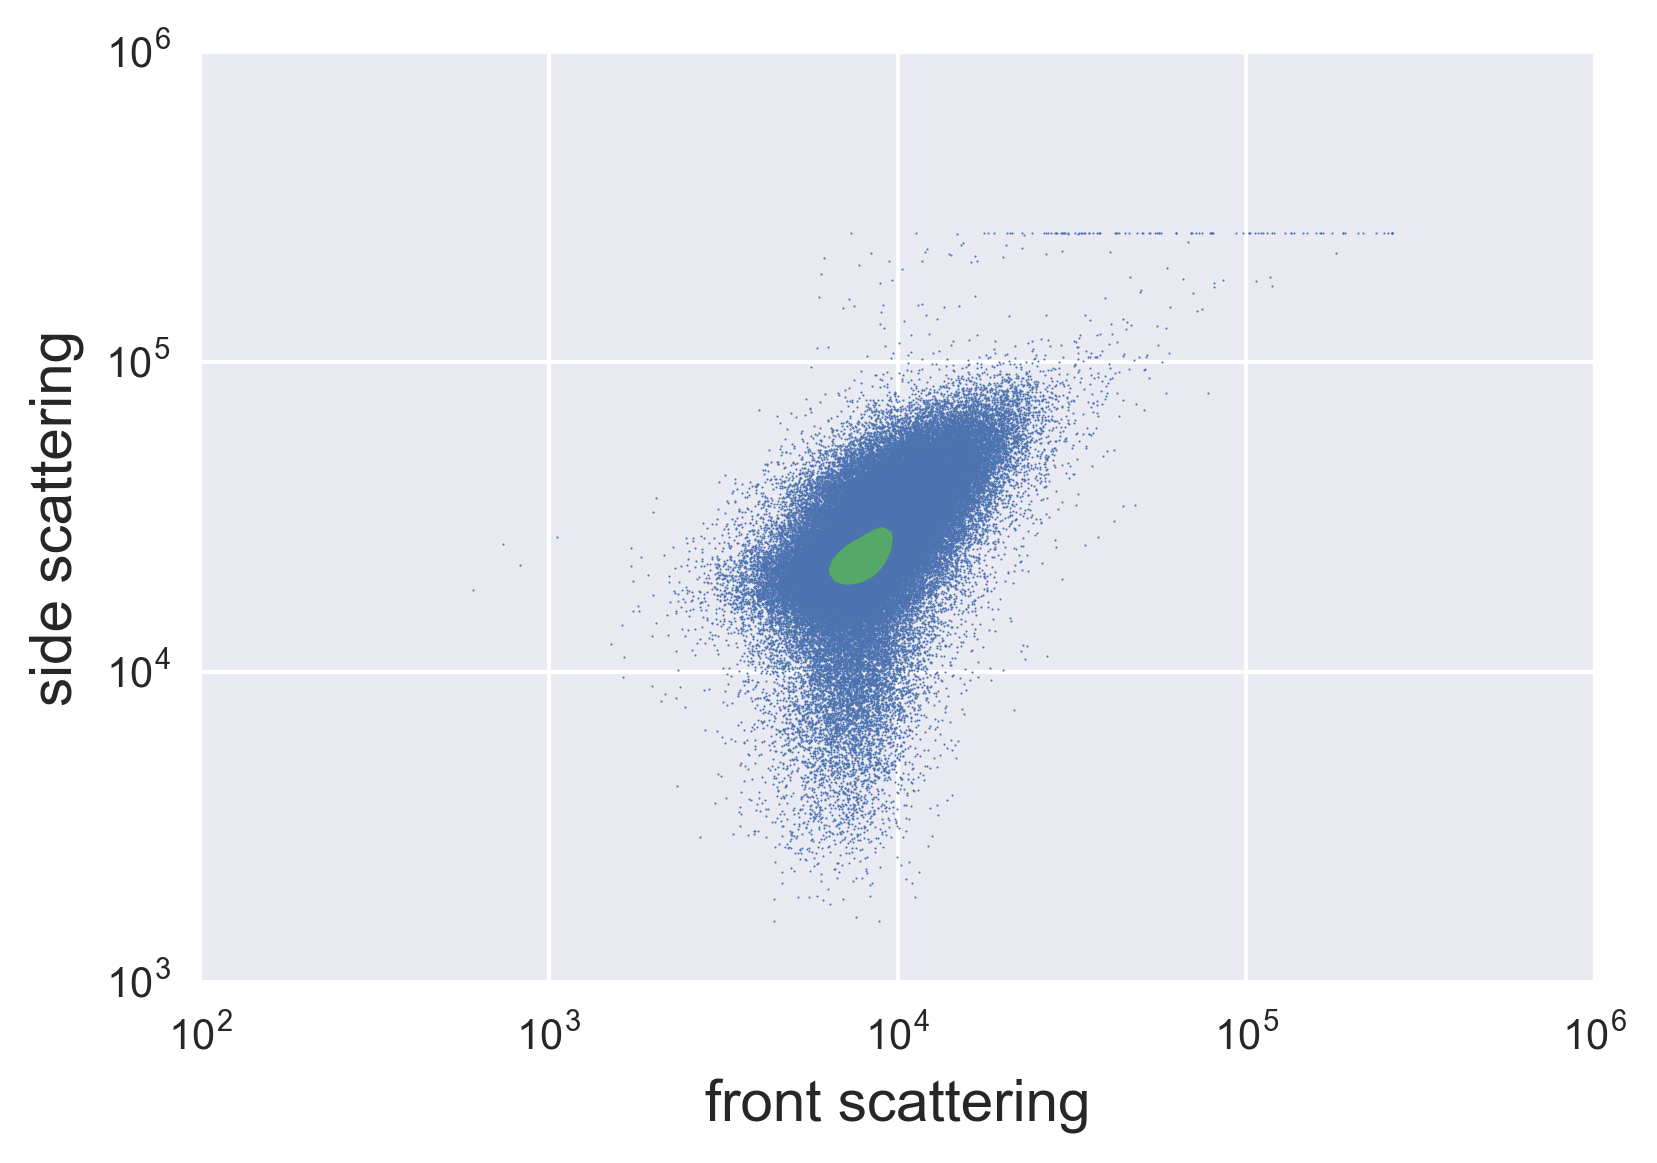

In [229]:
# Perform the gating
inds = gate_binning(fsc, ssc, percentile=80, smooth_sigma=0.01)

# Plot the excluded and included data
plt.loglog(fsc[~inds], ssc[~inds], '.', markersize=1, rasterized=True)
plt.loglog(fsc[inds], ssc[inds], '.', markersize=1, rasterized=True)
plt.xlabel('front scattering')
plt.ylabel('side scattering')

So, we got a nice subset of the data. Let's plot an ECDF of the fluorescent intensity values.

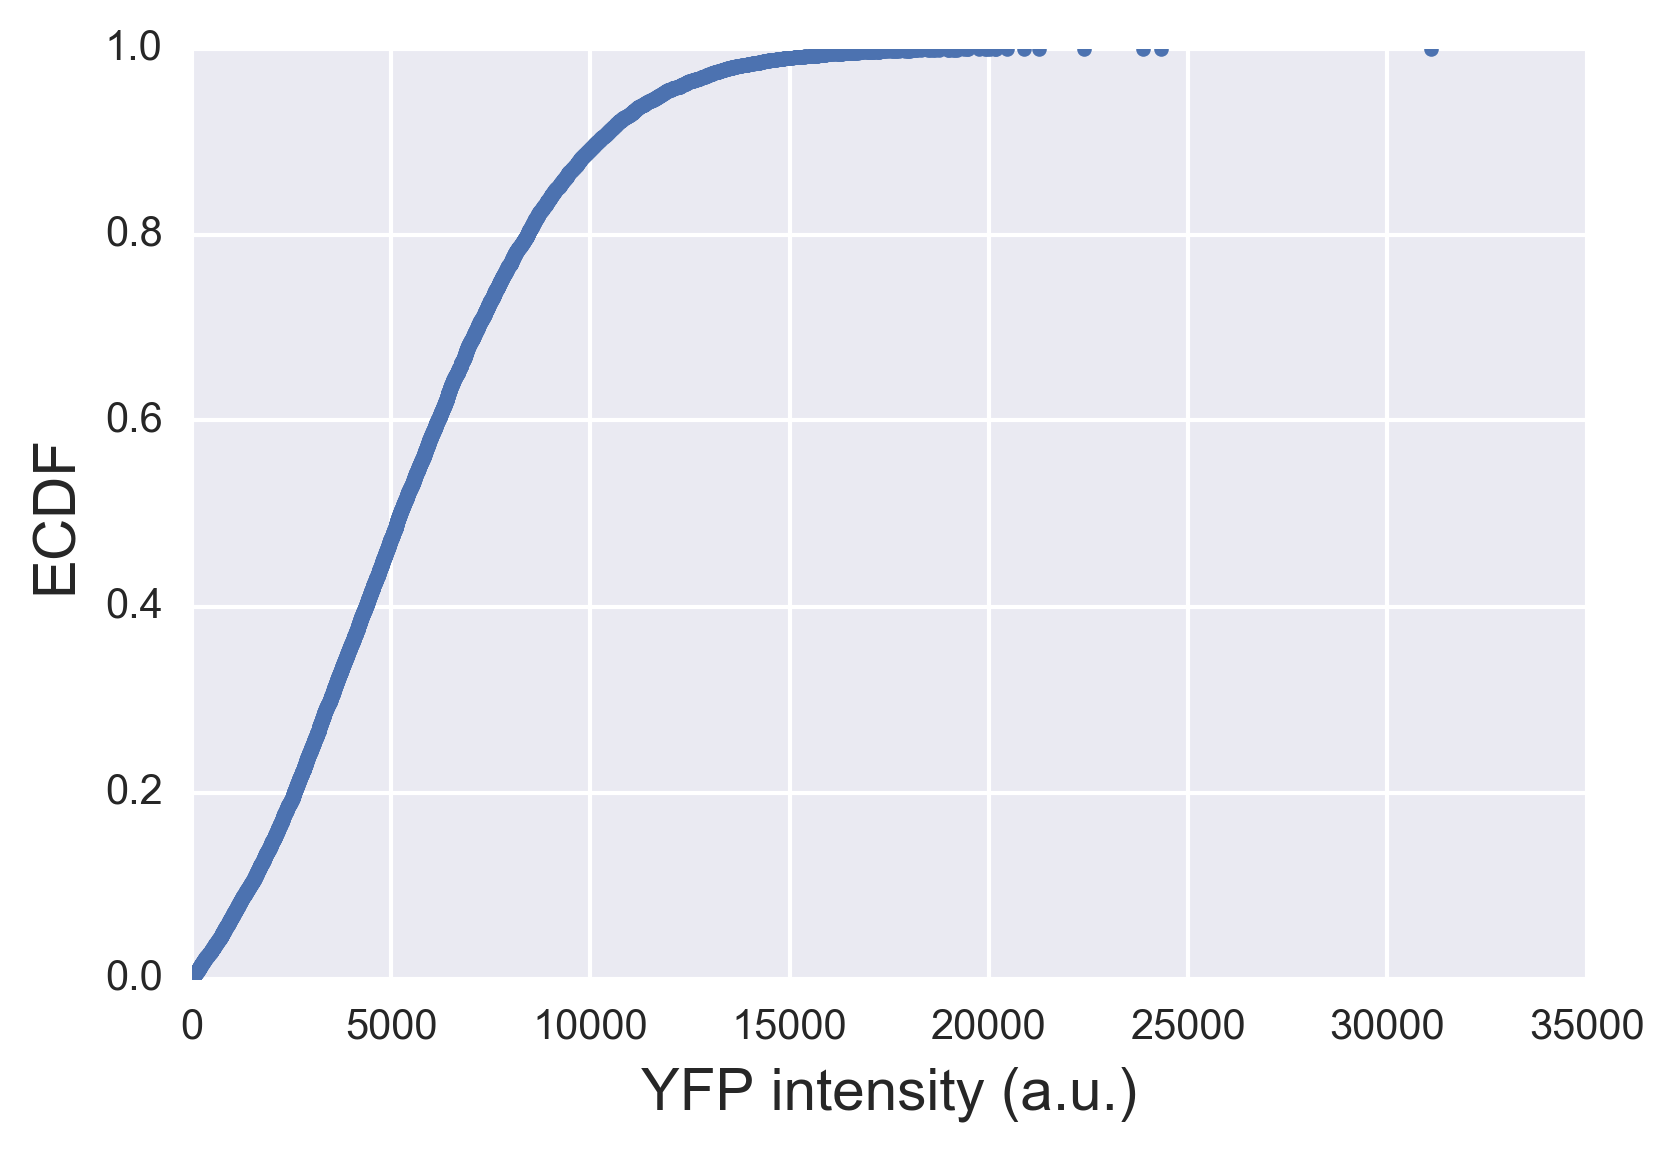

In [230]:
x, y = bebi103.ecdf(yfp[inds])
plt.plot(x, y, '.')
plt.xlabel('YFP intensity (a.u.)')
plt.ylabel('ECDF');

And here is the ECDF with all of the intensities.

## Below this is just junk I'm working on

Our gating strategy is as follows:
1. Perform 2D kernel density estimation on the FSA/SSA data.
2. Only take data points above a threshold density from the KDE.

In [55]:
inds = (df['FSC-A'] > 0) & (df['SSC-A'] > 0)
n = np.sum(inds)
d = 2
bw = 1 / n**(1/(d+4))
scatter_data = np.log10(df.loc[inds,['FSC-A', 'SSC-A']].values)

# Center and rescale data
scatter_data_scaled = np.empty_like(scatter_data)
scatter_data_scaled[:,0] = sklearn.preprocessing.scale(scatter_data[:,0])
scatter_data_scaled[:,1] = sklearn.preprocessing.scale(scatter_data[:,1])

kde = sklearn.neighbors.KernelDensity(bandwidth=bw)
kde.fit(scatter_data_scaled)

# # Set up the data grid for the contour plot
# X, Y = np.meshgrid(np.linspace(0, 50000), np.linspace(0, 150000))
# xy = np.vstack([Y.ravel(), X.ravel()]).T
# z = np.exp(kde.score_samples(xy))
# Z = z.reshape(X.shape)
# levels = np.linspace(0, Z.max(), 25)
# plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.14678017139684527,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0)

In [56]:
%timeit kde.score_samples([[-0.5, -0.5]])

100 loops, best of 3: 4.58 ms per loop


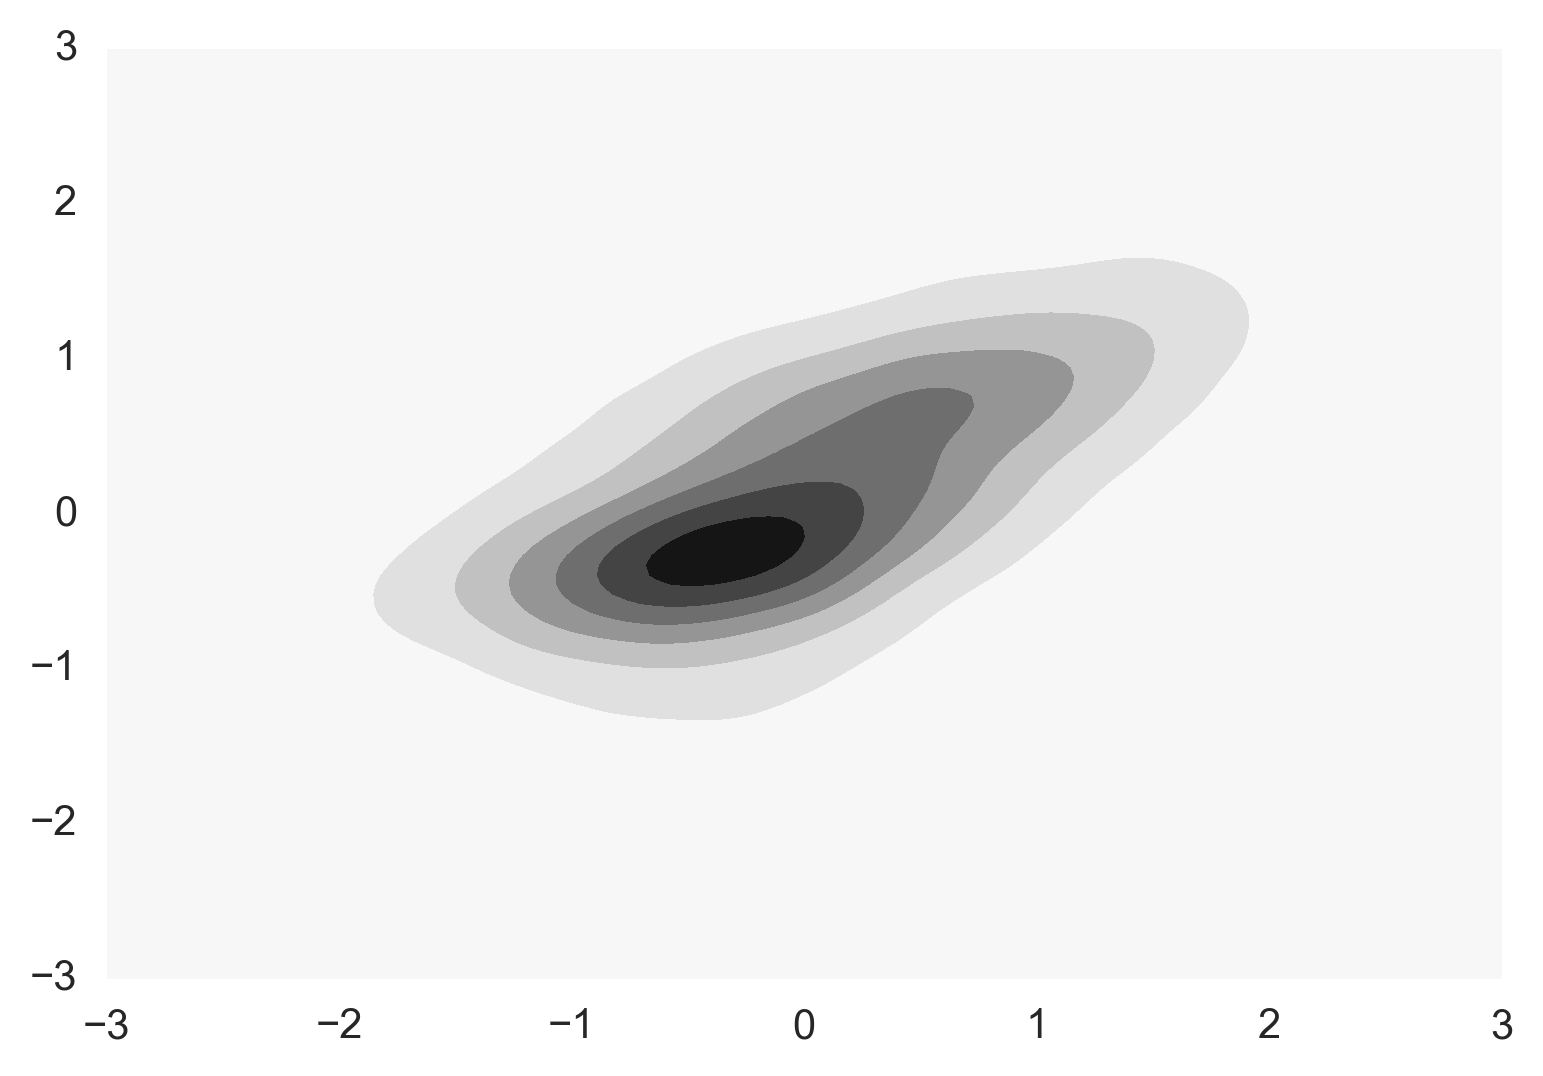

In [58]:
X, Y = np.mgrid[-3:3:100j, -3:3:100j]
positions = np.vstack([X.ravel(), Y.ravel()]).T
logpdf = np.reshape(kde.score_samples(positions), X.shape)
logpdf -= logpdf.max()
plt.contourf(X, Y, np.exp(logpdf))

-25467352616.753365

In [16]:
X, Y = np.mgrid[0:50000:100j, 0:150000:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
kernel = st.gaussian_kde(scatter_data.T)
Z = np.reshape(kernel(positions).T, X.shape)

In [24]:
kernel.silverman_factor()

0.14677992676220697

In [20]:
kernel.evaluate(scatter_data.T)

KeyboardInterrupt: 

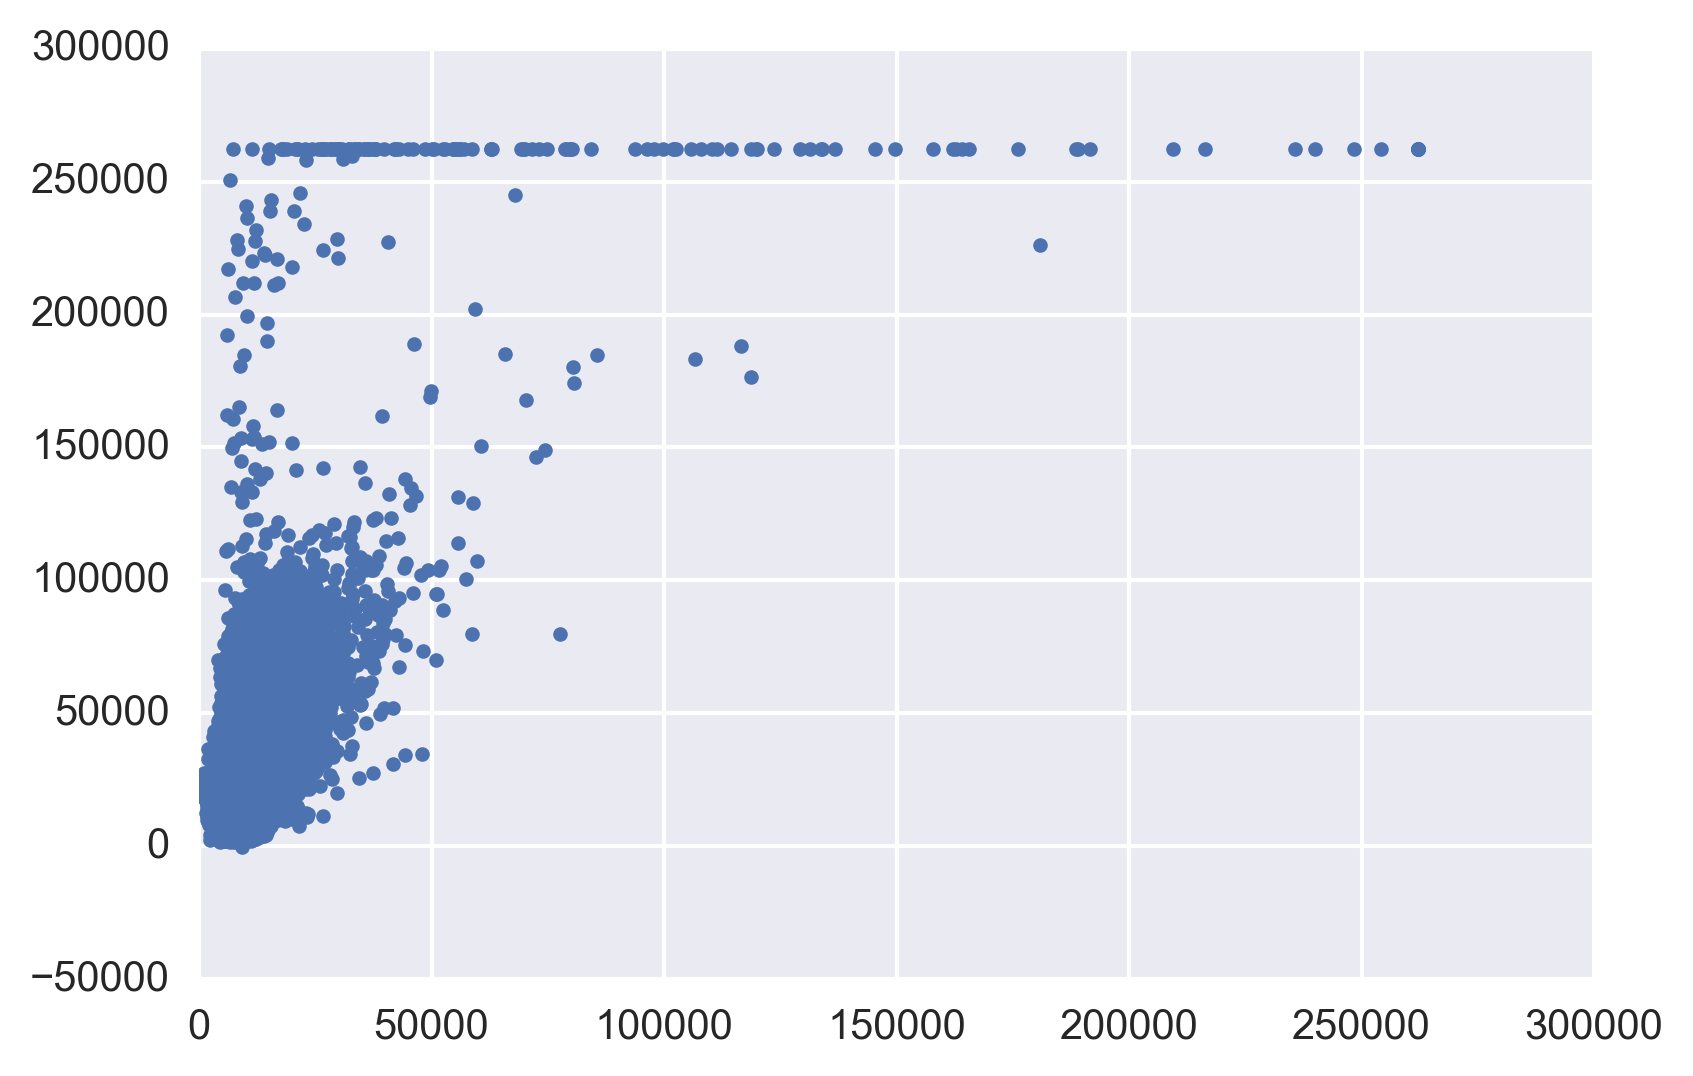

In [104]:
plt.plot(scatter_data[:,0], scatter_data[:,1], '.', rasterized=True)

In [101]:
Z

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [98]:
Z.min()

0.0

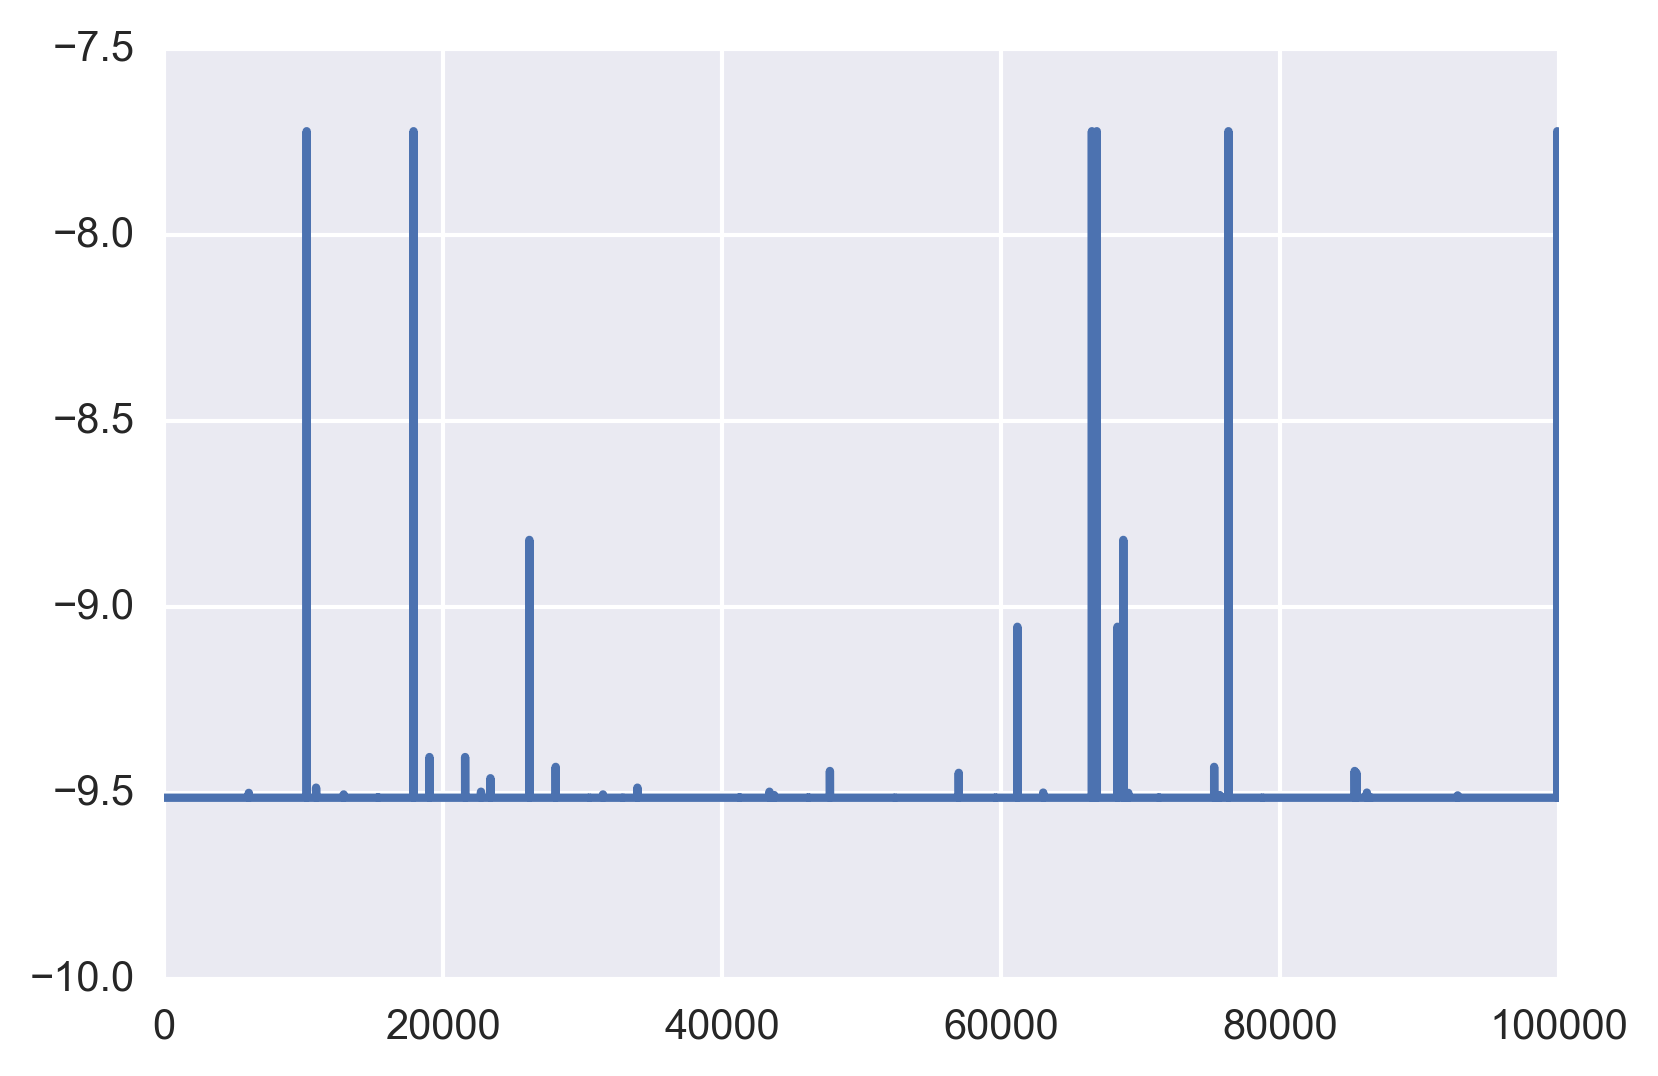

In [94]:
plt.plot(kde.score_samples(X))

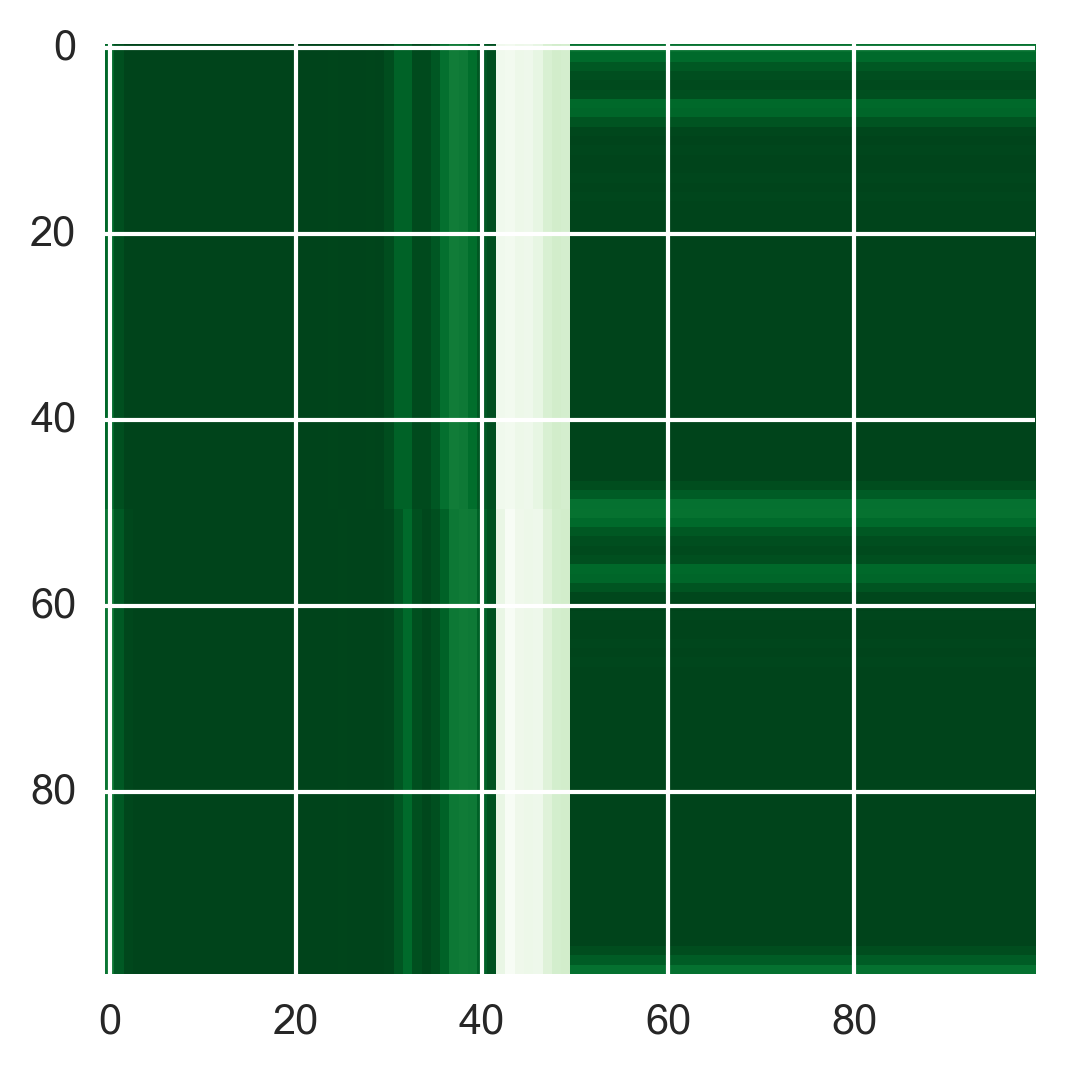

In [85]:
# set up grids. Borrowed from scipy.stats.gaussian_kde documentation.
X, Y = np.mgrid[0:40000:100j, 0:30000:100j]
positions = np.hstack([X.ravel(), Y.ravel()]).reshape(len(X.ravel()), 2)
Z = np.reshape(kde.score_samples(positions).T, X.shape)

plt.imshow(np.rot90(Z), cmap='Greens')

In [81]:
np.hstack([X.ravel(), Y.ravel()]).reshape(len(X.ravel()), 2).shape

(10000, 2)

In [70]:
X

array([[  9540.33886719,  23248.2109375 ],
       [  4667.03759766,   9251.27246094],
       [  5275.00244141,  19137.51367188],
       ..., 
       [ 11333.83789062,  53215.09375   ],
       [  6602.95800781,  26406.18359375],
       [  9157.43066406,  32998.87890625]])

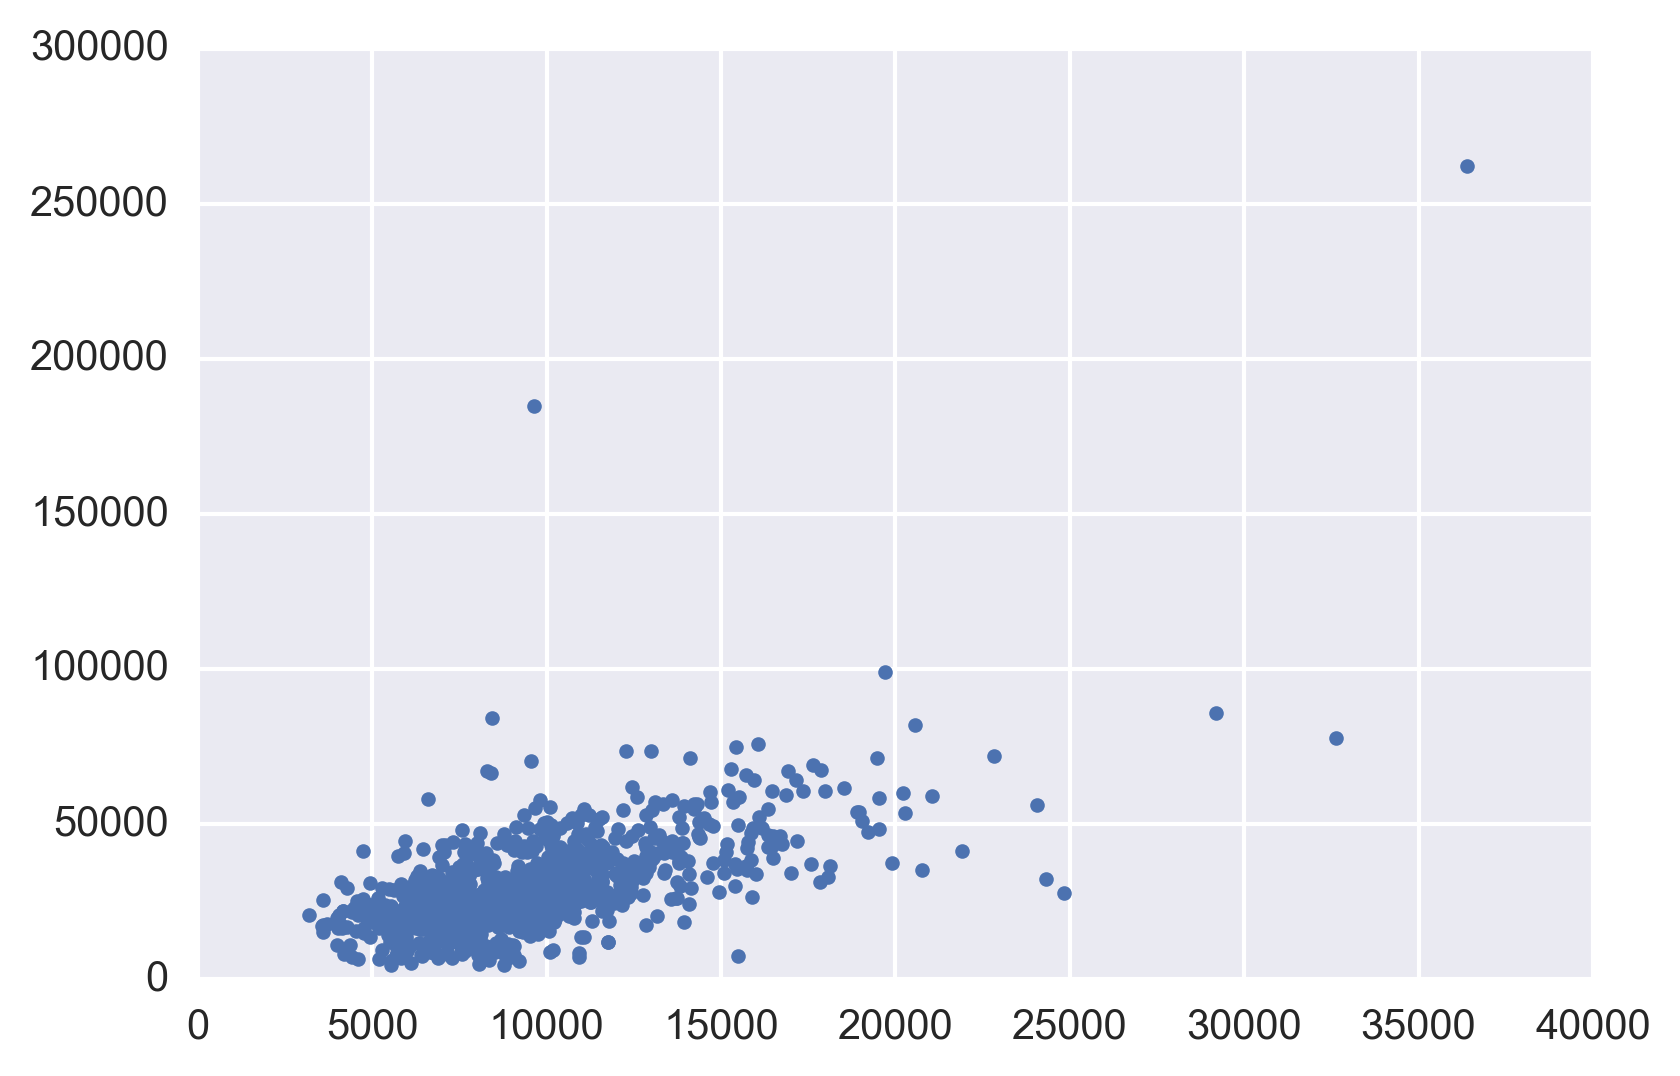

In [63]:
plt.plot(samples[:,0], samples[:,1], '.')

In [58]:
scores

array([-9.51316071, -9.51316071, -9.51316071, ..., -9.51316071,
       -9.51316071, -9.51316071])

In [12]:
df['FSC-A-log'] = np.log10(df['FSC-A'])
df['SSC-A-log'] = np.log10(df['SSC-A'])

/Users/Justin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


(10000.0, 100000.0)

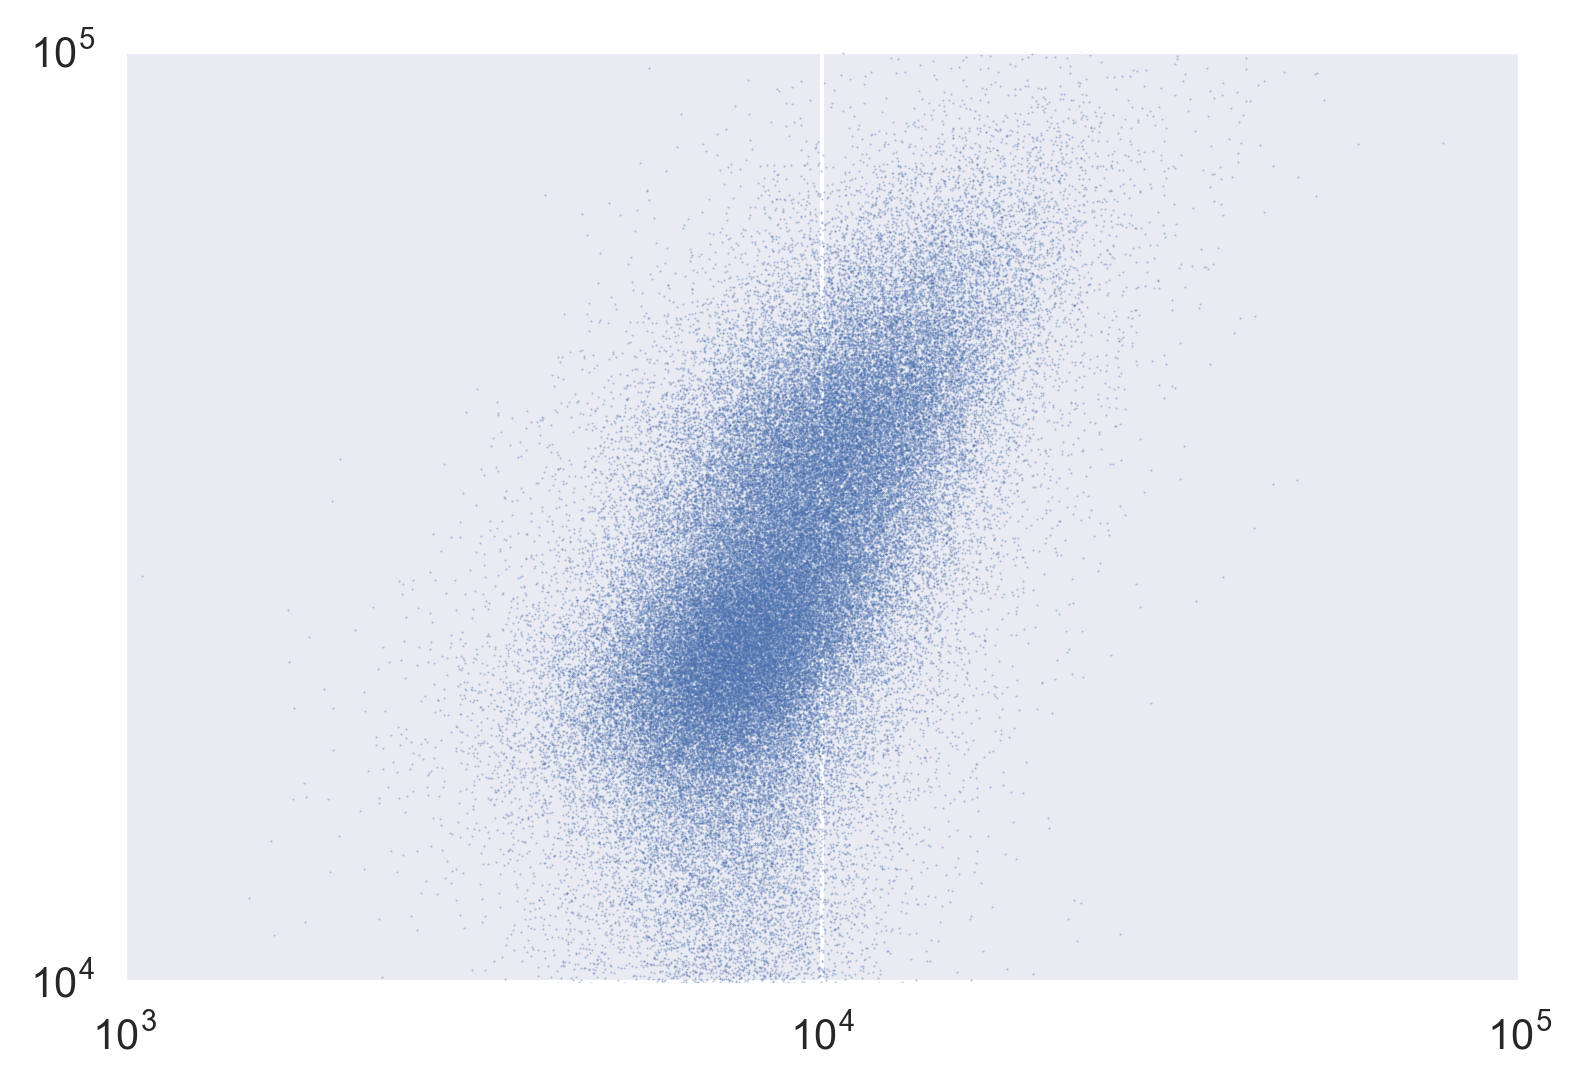

In [11]:
plt.loglog(df['FSC-A'], df['SSC-A'], '.', markersize=1, alpha=0.4, rasterized=True)
plt.xlim(1e3, 1e5)
plt.ylim(1e4, 1e5)

/Users/Justin/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


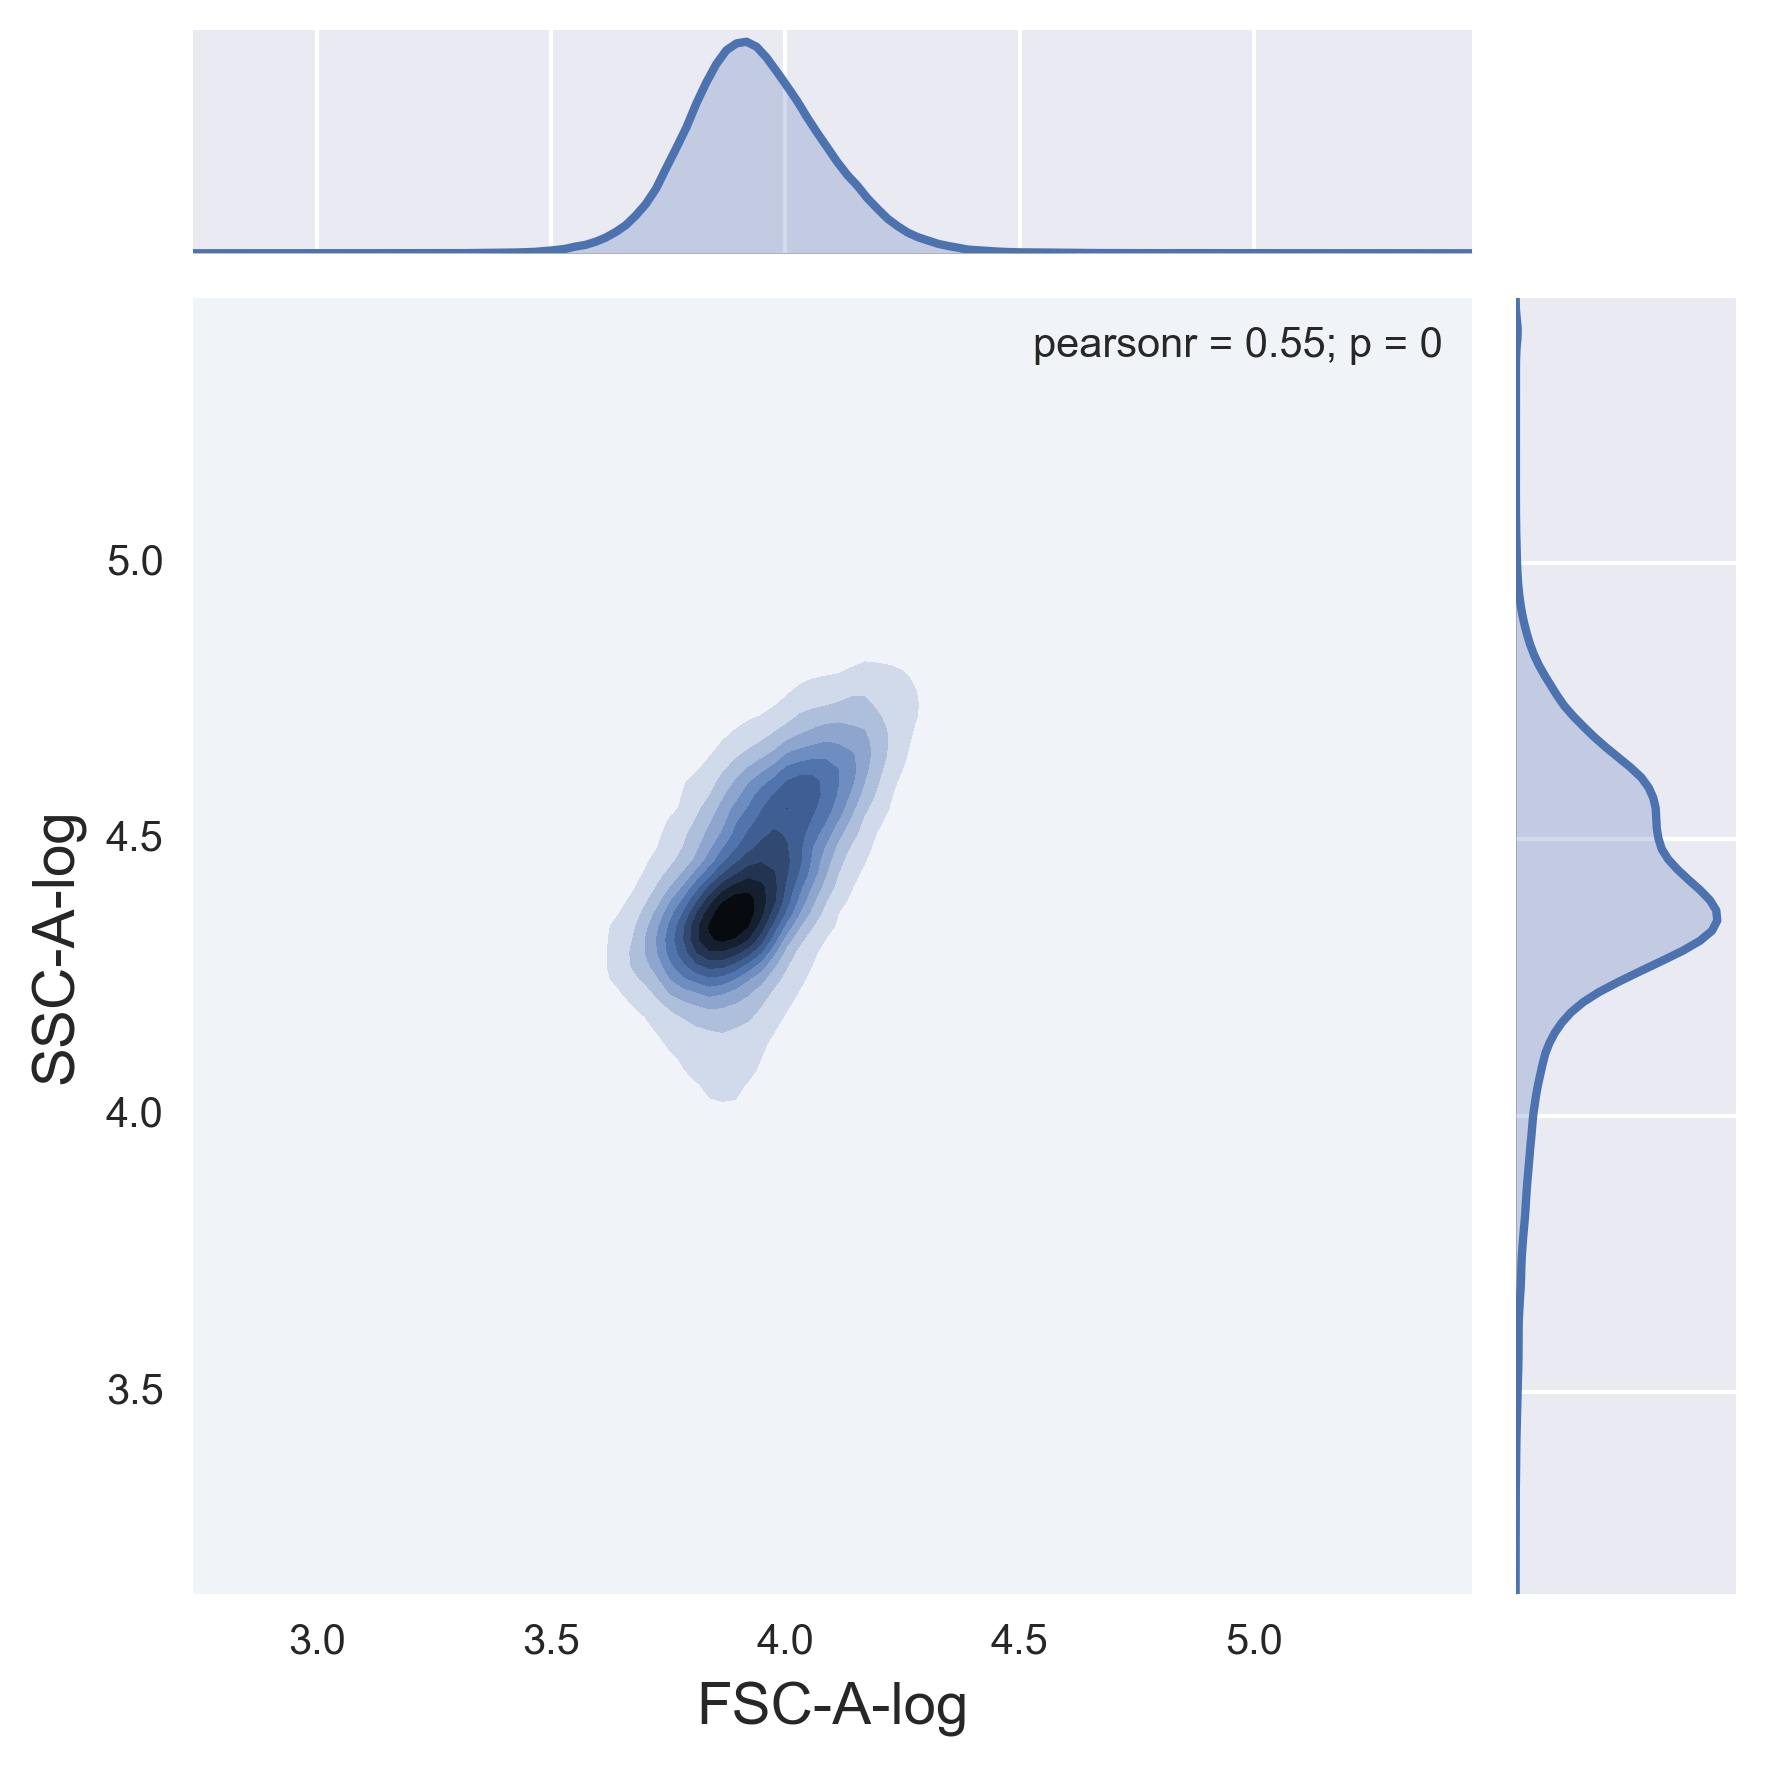

In [14]:
sns.jointplot(data=df, x='FSC-A-log', y='SSC-A-log', kind='kde')

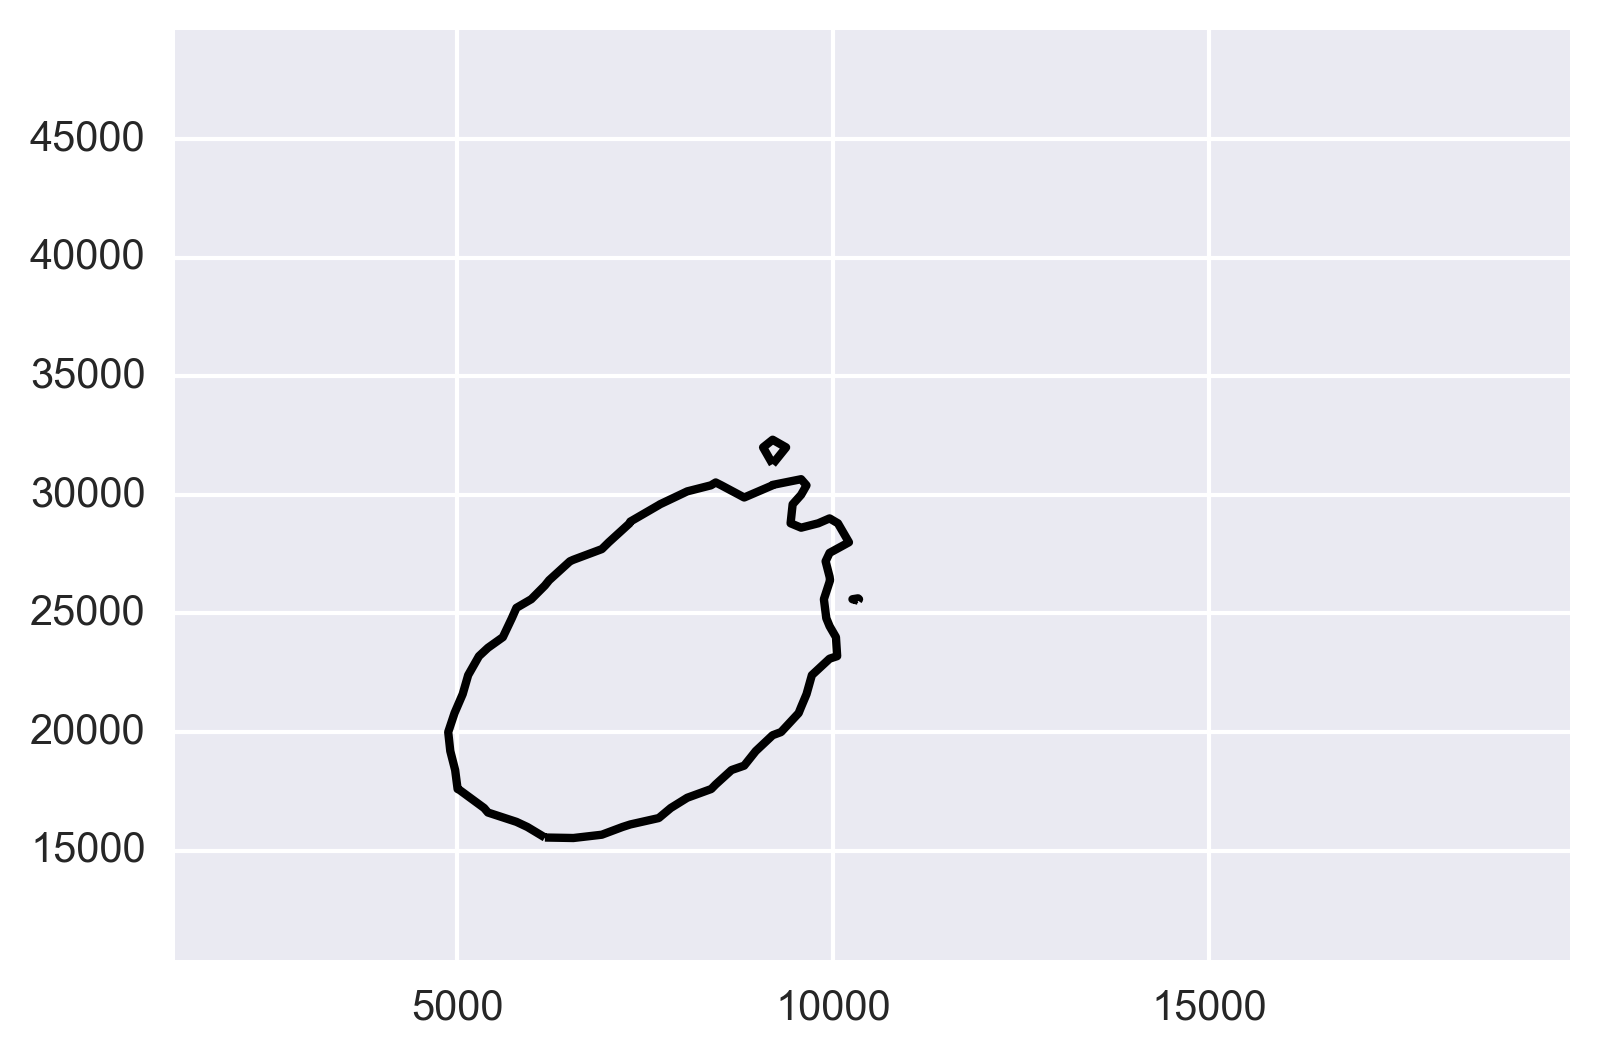

In [41]:
inds = np.logical_and(np.logical_and(df['FSC-A'] > 1e3, df['FSC-A'] < 2e4), 
                      np.logical_and(df['SSC-A'] > 1e4, df['SSC-A'] < 5e4))
fsc = df.loc[inds, 'FSC-A']
ssc = df.loc[inds, 'SSC-A']

count, x, y = bebi103.norm_cumsum_2d(fsc, ssc, nbins=50)
quadset = plt.contour(x, y, count, levels=([0.4]), cmap=plt.cm.gray)

In [42]:
quadset.allsegs

[[array([[  6167.88515869,  15557.76005218],
         [  5935.07061271,  16001.82402344],
         [  5789.35418701,  16218.18619037],
         [  5410.82321533,  16610.75336528],
         [  5359.38447555,  16801.77191406],
         [  5032.29224365,  17562.77719846],
         [  5007.30057383,  17601.71980469],
         [  4974.56119014,  18401.66769531],
         [  4909.99995052,  19201.61558594],
         [  4882.39980883,  20001.56347656],
         [  4966.31663856,  20801.51136719],
         [  5032.29224365,  21288.14433631],
         [  5075.00852581,  21601.45925781],
         [  5147.72273134,  22401.40714844],
         [  5291.29715517,  23201.35503906],
         [  5410.82321533,  23553.58958187],
         [  5608.98613486,  24001.30292969],
         [  5728.65937087,  24801.25082031],
         [  5789.35418701,  25237.7125318 ],
         [  5986.58962904,  25601.19871094],
         [  6167.88515869,  26178.77552071],
         [  6224.37623823,  26401.14660156],
         [